# Periodic stimulus

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt


import os, sys
rootpath = os.path.join(os.getcwd(), '..')


sys.path.append(rootpath)



from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt
import diffrax
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


In [2]:
#alternative laplacian to be checked

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

N_x=200
N_y=200
L1, c1=generate_laplacian(N_x, N_x, 0, sparse_matrix=True,seed=2)



#Deterministic implementation

In [3]:

def FHN_graph(t, y, args):
    N, a, b, e, Du, L, c_blocks = args 
    u = y[:N]
    v = y[N:]
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)

    return jnp.append(du, dv)

def solve_heart(N=200*200, a=3, b=0.2, e=1e-2, Du=0.2, T=6000, L=None, c1=None, max_steps=1000000, save_points_per_segment=2000,
                solver=diffrax.Dopri8(), rtol=1e-6, atol=1e-7, dt0=1e-2):
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    # Calculate indices outside the periodic_stimulus function
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]

    term = ODETerm(FHN_graph)

    def run_segment(carry, t_start):
        y0, all_solutions, idx = carry
        y0 = jax.lax.cond(t_start == 0,
                          lambda _: jnp.zeros(2 * N, dtype=jnp.float32).at[indices].set(0.1),
                          lambda y0: y0,
                          y0)
        t_end = t_start + 1300
        saveat = SaveAt(ts=jnp.linspace(t_start, t_end, save_points_per_segment))  # Save specified points for each segment
        sol = diffeqsolve(term, solver, t_start, t_end, dt0, y0, args=(N, a, b, e, Du, L, c1),
                          saveat=saveat, max_steps=max_steps, stepsize_controller=stepsize_controller)
        all_solutions = jax.lax.dynamic_update_slice(all_solutions, sol.ys, [idx, 0])
        y0 = sol.ys[-1]

        # Apply stimulus to the specified indices
        y0 = jax.lax.cond(t_start == 0,
                          lambda y0: y0.at[indices].set(0.1),
                          lambda y0: y0.at[indices].add(0.1),
                          y0)

        return (y0, all_solutions, idx + sol.ys.shape[0]), None

    # Preallocate the array for all_solutions with the correct shape
    num_segments = T // 1300
    segment_length = save_points_per_segment  # Save specified points for each segment
    initial_solutions = jnp.empty((num_segments * segment_length, 2 * N), dtype=jnp.float32)
    carry = (jnp.zeros(2 * N, dtype=jnp.float32), initial_solutions, 0)

    # Run the simulation in segments using jax.lax.scan
    t_starts = jnp.arange(0, T, 1300)
    carry, _ = jax.lax.scan(run_segment, carry, t_starts)

    # Extract the full solution
    full_solution = carry[1]

    return full_solution



In [ ]:

N_y=200
N_x=200
N=N_x*N_y
dts=750
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0,sparse_matrix=True, seed=2)
sol = solve_heart(T=5250,N=N,a=3,b=0.05,Du=0.04, L=L1,c1=c1,save_points_per_segment=dts)
L2, c2=generate_laplacian(N_x, N_x, conduction_block_threshold=0.3,sparse_matrix=True, seed=2)
sol1=solve_heart(T=5250,N=N,a=3,b=0.05,Du=0.04, L=L2,c1=c2,save_points_per_segment=dts)
L3, c3=generate_laplacian(N_x, N_x, conduction_block_threshold=0.5,sparse_matrix=True, seed=2)
sol2=solve_heart(T=5250,N=N,a=3,b=0.05,Du=0.04, L=L3,c1=c3,save_points_per_segment=dts)
L4, c4=generate_laplacian(N_x, N_x, conduction_block_threshold=0.8,sparse_matrix=True, seed=2)
sol3=solve_heart(T=5250,N=N,a=3,b=0.05,Du=0.04, L=L4,c1=c4,save_points_per_segment=dts)

In [ ]:
u_sol = sol[:,:N].T 
u_sol1 = sol1[:,:N].T   
u_sol2 = sol2[:,:N].T
u_sol3 = sol3[:,:N].T
v_sol = sol[:,N:].T
v_sol1 = sol1[:,N:].T
v_sol2 = sol2[:,N:].T
v_sol3 = sol3[:,N:].T


In [4]:
N=200*200

L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.50,sparse_matrix=True, seed=60)
sol = solve_heart(T=6500,N=N,a=3,b=0.05,Du=0.04, L=L1,c1=c1,save_points_per_segment=1300)
u_sol = sol[:,:N].T 

# Kuramoto order parameter

In [5]:
def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)




In [9]:


def binary_phase_interpolation(u, u_thresh):
    """
    Simplifies the phase extraction by:
    1. Setting the array to 1 where u(t) > u_thresh and 0 where u(t) <= u_thresh.
    2. Assigning phase = 0 where u(t) = 0.
    3. Interpolating phase from 0 to 2π over each continuous 1-segment followed by a continuous 0-segment.

    Parameters:
    ----------
    u : jnp.ndarray
        2D array of membrane potential (N oscillators, T time steps).
    u_thresh : float
        Threshold potential for spike initiation.

    Returns:
    -------
    phase : jnp.ndarray
        2D array of phase for each oscillator at each time point (N oscillators, T time steps).
    """
    # Binary mask: 1 if u > u_thresh, 0 otherwise
    binary_u = jnp.where(u > u_thresh, 1, 0)

    # Initialize phase array
    N, T = u.shape
    phase = jnp.zeros_like(u, dtype=float)

    for i in range(N):
        one_segments = jnp.where(jnp.diff(binary_u[i, :], prepend=0) == 1)[0]  # Start of 1-segments
        zero_segments = jnp.where(jnp.diff(binary_u[i, :], prepend=0) == -1)[0]  # End of 1-segments

        # Ensure matching pairs of start and end indices
        if zero_segments.size < one_segments.size:
            zero_segments = jnp.append(zero_segments, T)

        for start, end in zip(one_segments, zero_segments):
            next_start = jnp.where(one_segments > end)[0]
            if next_start.size > 0:
                next_start = one_segments[next_start[0]]
            else:
                next_start = T

            length = next_start - start
            segment_phase = jnp.linspace(0, 2 * jnp.pi, length, endpoint=False)
            phase = phase.at[i, start:next_start].set(segment_phase)

    return phase

In [28]:
def find_transitions(binary_array):
    """
    Find all the indices in T where the value for each n in N goes from 0 to 1.

    Parameters:
    ----------
    binary_array : jnp.ndarray
        2D array of binary values (N oscillators, T time steps).

    Returns:
    -------
    transitions : list of jnp.ndarray
        List of arrays, each containing the indices in T where the value goes from 0 to 1 for each n in N.
    """
    N, T = binary_array.shape
    transitions = []

    for i in range(N):
        # Find indices where the value goes from 0 to 1
        transition_indices = jnp.where(jnp.diff(binary_array[i, :], prepend=0) == 1)[0]
        transitions.append(transition_indices)

    return transitions

In [ ]:
# This function doesn't work sadly

def interpolate_phases(transitions, T):
    """
    Interpolates the times between each two subsequent indices with values between 0 and 2π to define a phase.

    Parameters:
    ----------
    transitions : list of jnp.ndarray
        List of arrays, each containing the indices in T where the value goes from 0 to 1 for each n in N.
    T : int
        Total number of time steps.

    Returns:
    -------
    phase : jnp.ndarray
        2D array of phase for each oscillator at each time point (N oscillators, T time steps).
    """
    N = len(transitions)
    phase = jnp.zeros((N, T), dtype=float)

    def interpolate_segment(carry, segment):
        start, end = segment
        length = end - start
        segment_phase = jnp.linspace(0, 2 * jnp.pi, length.astype(int), endpoint=False)
        phase = carry.at[start:end].set(segment_phase)
        return phase, None

    for i in range(N):
        segments = jnp.stack([transitions[i][:-1], transitions[i][1:]], axis=1)
        phase, _ = lax.scan(interpolate_segment, phase[i], segments)
        phase = phase.at[i, transitions[i][-1]:].set(0)  # Set phase to 0 after the last transition

    return phase

In [38]:
u_sol=u_sol.reshape(N_x,N_y,-1)
#u_sol2=u_sol2.reshape(N_x,N_y,-1)
c1=c1.reshape(N_x,N_y)
cnot=~c1[4:(N_x-4), 150]
#mask = u_sol[4:(N_x-4), 5, :] == 0
#mask = jnp.all(u_sol[4:(N_x-4), 5, :] == 0, axis=1)
#print(mask.shape)
#print(cnot.shape)
#cnot=cnot &~ mask
usol_phase=u_sol[4:(N_x-4),150,:]
print(usol_phase[cnot,:].shape)
binary_u = jnp.where(usol_phase[cnot,:] > 0.08, 1, 0)
transitions=find_transitions(binary_u)

print(len(transitions))
phase=interpolate_phases(transitions,usol_phase.shape[1])
print(phase.shape)
#phase= binary_phase_interpolation(usol_phase[cnot,:], 0.08)

(85, 6500)
85


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[].
'num' argument of jnp.linspace
The error occurred while tracing the function interpolate_segment at C:\Users\pelli\AppData\Local\Temp\ipykernel_29076\3443972768.py:22 for scan. This concrete value was not available in Python because it depends on the value of the argument segment.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

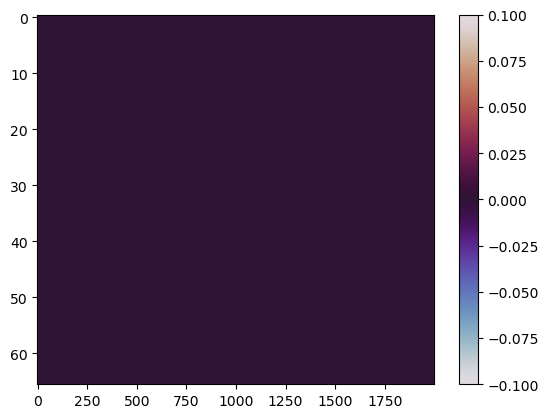

In [12]:
plt.imshow(phase, aspect='auto', cmap='twilight', interpolation='None')
plt.colorbar()

In [ ]:

def kuramoto_order_parameter(array):
    """
    Calculate the Kuramoto order parameter for an array of phases.
    Parameters:
    array (jnp.ndarray): Array of phases with shape (N, T).
    Returns:
    R (jnp.ndarray): Array of Kuramoto order parameters with shape (T,).
    Psi (jnp.ndarray): Array of Kuramoto order parameter phases with shape (T,).
    """

    N, T = array.shape
    
    # Calculate the complex exponential of the phases
    exp_phases = jnp.exp(1j * array)
    
    # Calculate the Kuramoto order parameter
    R = jnp.abs(jnp.sum(exp_phases, axis=0)) / N
    Psi = jnp.angle(jnp.sum(exp_phases, axis=0))
    
    return R, Psi



In [8]:
u_sol=u_sol.reshape(N_x, N_y, 6500)


c1=c1.reshape(N_x,N_y)
cnot=~c1[4:(N_x-4), 150]

usol_phase=u_sol[4:(N_x-4),150,3900:5900]
phase= binary_phase_interpolation(usol_phase[cnot,:], 0.08)
R,psi= kuramoto_order_parameter(phase)

In [9]:
R, psi= kuramoto_order_parameter(phase[:,:])

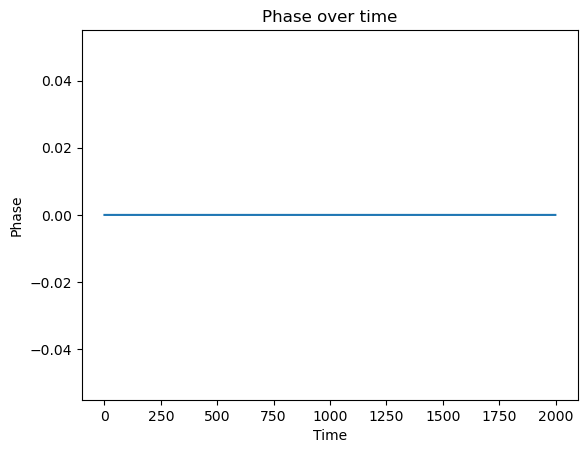

In [10]:
# Wrap phase values within the range of -π to π
wrapped_psi = (psi + jnp.pi) % (2 * jnp.pi) - jnp.pi

plt.plot(wrapped_psi)
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Phase over time')
plt.show()

0.0


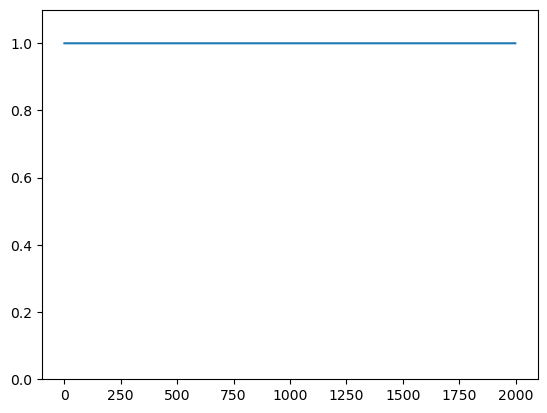

In [11]:

plt.plot(R)
#print(jnp.mean(R[1000:]))
plt.ylim(0,1.1)
r = jax.lax.cond(jnp.all(psi == 0), lambda _: 0.0, lambda _: jnp.mean(R), operand=None)
print(r)

In [ ]:
kuramoto=[]
dts=1300
tdts=6500
N=200*200
# Loop over conduction threshold values
for i, conduction_threshold in enumerate(jnp.arange(0, 1.1, 0.01)):
    seed = int(conduction_threshold * 1000)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed)   
    print("{}/{}, m={}".format(i+1,len(jnp.arange(0,1.1,0.01)), conduction_threshold))
    sol = solve_heart(T=6500,a=3,b=0.05,Du=0.04, L=L1, c1=c1,save_points_per_segment=dts)
    u_sol = sol[:,:N].T 
    v_sol = sol[:,N:].T

    u_sol=u_sol.reshape(N_x, N_y, tdts)
    v_sol=v_sol.reshape(N_x, N_y, tdts)
    
    c1=c1.reshape(N_x,N_y)
    cnot=~c1[4:(N_x-4), 150]
#print(cnot.shape)
    usol_phase=u_sol[4:(N_x-4),150,3900:5900]
    phase= binary_phase_interpolation(usol_phase[cnot,:], 0.08)
    R,psi= kuramoto_order_parameter(phase)
    r = jax.lax.cond(jnp.all(psi == 0), lambda _: 0.0, lambda _: jnp.mean(R), operand=None)
    
    kuramoto.append(r)
    

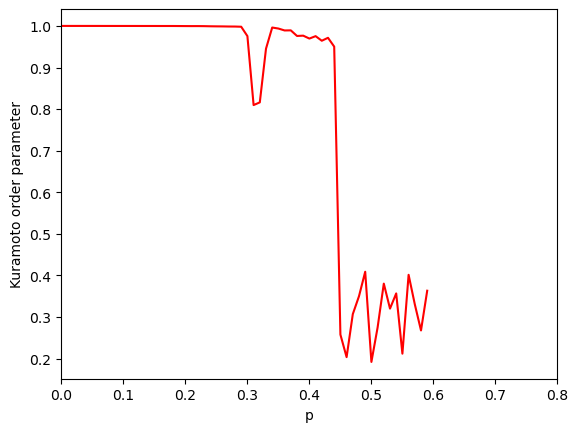

In [ ]:
kuramoto = jnp.array(kuramoto)
plt.plot(jnp.arange(0, 0.8, 0.01), kuramoto,c='r')
plt.xlabel('p')
plt.ylabel('Kuramoto order parameter')
plt.xlim(0, 0.8)

#plt.legend()
#plt.title('Kuramoto order parameter vs. conduction threshold')

plt.show()


# Entropy calculation PSD

In [111]:
# entropy calculations without going to rate or activity
def average_entropy(array, c1):
    '''
    Calculate the average Shannon entropy of the power spectrum of the elements of an array disregarding the ones that are conduction blocks and excluding the first and last column and the top and bottom row.
    Parameters:
    - array (jax.numpy.ndarray): A 3D array of shape (N, M, T) where N is the number of rows, M is the number of columns, and T is the number of time steps.
    - c1 (jax.numpy.ndarray): A binary matrix of shape (N, M) where True values indicate conduction blocks.
    Returns:
    - average_entropy (float): The average Shannon entropy of the power spectrum of the elements of the array.
    '''
    N, M, T = array.shape
    
    # Exclude the first and last column and the top and bottom row
    array = array[4:N-4, 4:M-4, :]
    c1 = c1[4:N-4, 4:M-4]
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M-4)))(jnp.arange(N-4))
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy
@jit
def calculate_entropy(power_spectrum):
    '''
    Calculate the entropy of a power spectrum.
    Parameters:
    power_spectrum (jax.numpy.ndarray): The power spectrum of a signal.
    Returns:
    float: The entropy of the power spectrum.
    '''
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative


@jit
def process_element(array, i, j):
    '''
    Process a single element of an array to calculate its Shannon entropy.
    '''
    fft_result_shifted = jnp.fft.fftshift(jnp.fft.fft(array[i, j, :]))  # FFT and shift in one line
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    
    # Check if the power spectrum is normalized
    power_spectrum_sum = jnp.sum(power_spectrum)
    power_spectrum_normalized = jnp.allclose(power_spectrum_sum, 1.0, atol=1e-5)
    
    # Calculate entropy or return NaN if not normalized
    entropy = lax.cond(
        power_spectrum_normalized,
        lambda _: calculate_entropy(power_spectrum),
        lambda _: jnp.nan,
        operand=None
    )
    return entropy




## Stochastic heart

In [4]:
import jax.numpy as jnp
import jax.random as random
from jax import lax

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)
        
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)

        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Create a range of steps
    steps = jnp.arange(num_steps)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), steps)

    return u_trajectory, v_trajectory



In [14]:
delta_t=0.1
sol=[]

for i in range(2): 
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=3000, stimulus_time=1000)
    sol.append(u_sol[:,2000])
    delta_t+=0.01


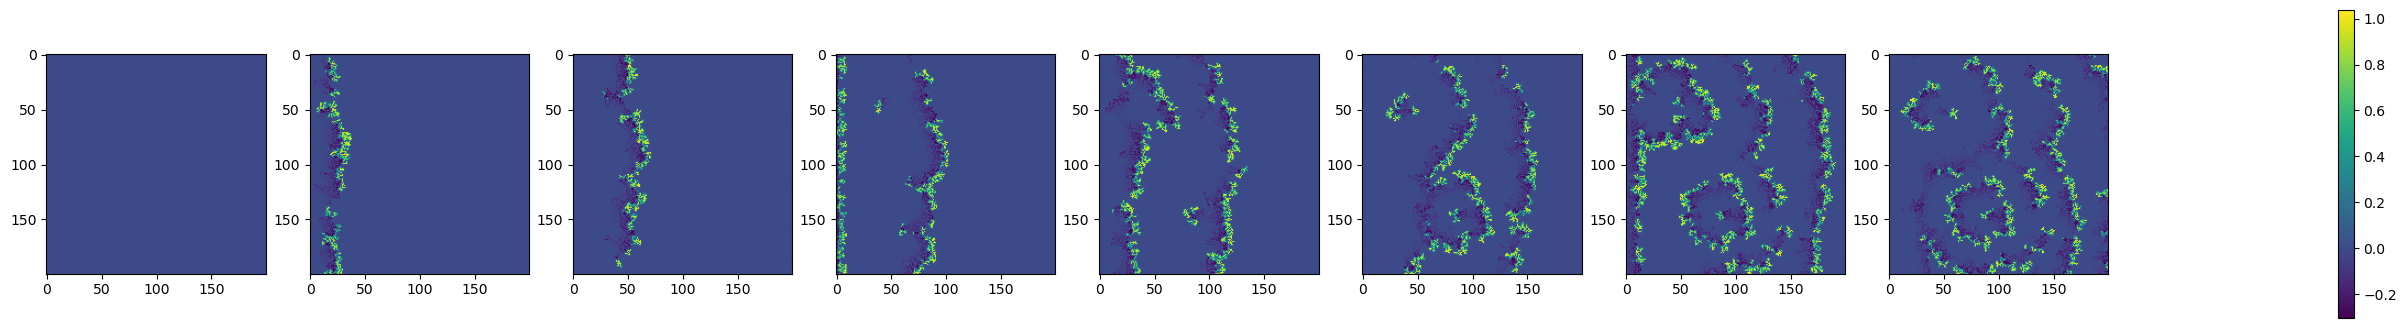

In [16]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol.min()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*int(3000/0.1))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


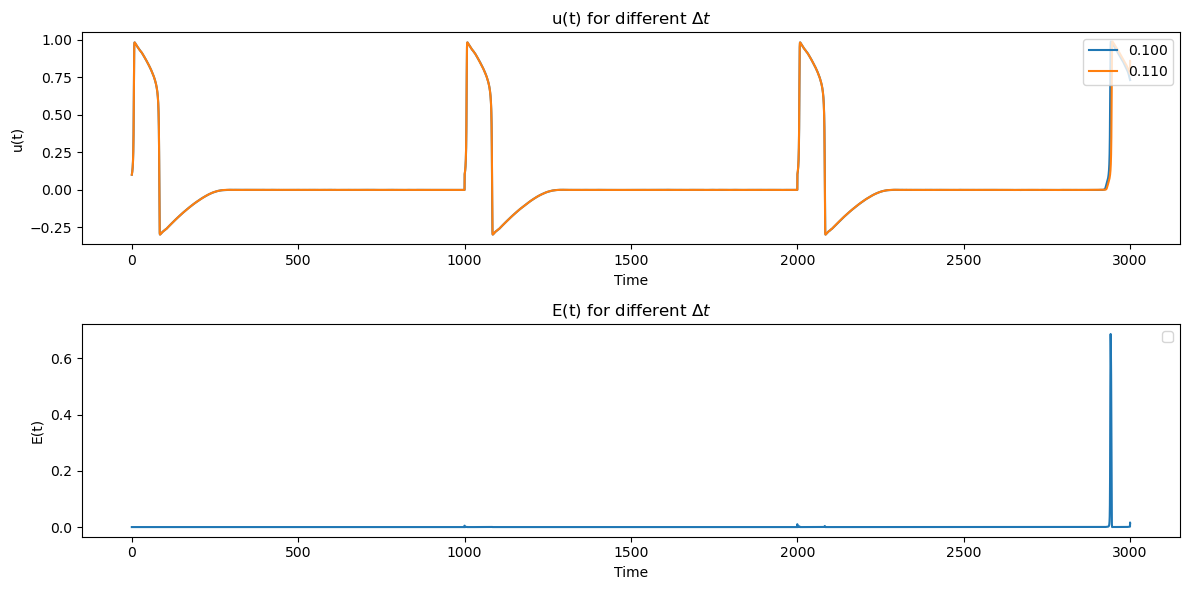

In [15]:

from scipy.interpolate import interp1d

time1=np.linspace(0, 3000, int(3000 / (0.1 )))
time2=np.linspace(0, 3000, int(3000 / (0.1 +  0.01)))
# Define the common time points
common_time = np.linspace(0, min(time1[-1], time2[-1]), num=min(len(time1), len(time2)))

# Interpolate both arrays to the common time points
interpolator1 = interp1d(time1, sol[0], kind='linear', fill_value="extrapolate")
interpolator2 = interp1d(time2, sol[1], kind='linear', fill_value="extrapolate")

sol1_common = interpolator1(common_time)
sol2_common = interpolator2(common_time)

# Perform the subtraction
s = (sol1_common - sol2_common)**2


for i in range(1):
    plt.figure(figsize=(12, 6))
    
    # Plot the time series
    plt.subplot(2, 1, 1)
    for j in range(2):
        plt.plot(np.linspace(0, 3000, int(3000 / (0.1 + j * 0.01))), sol[j][:], label=f"{0.1 + j * 0.01:.3f}")
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.legend(loc='upper right')
    plt.title(r'u(t) for different $\Delta t$')

    # Plot the histograms
    plt.subplot(2, 1, 2)
    '''
    for j in range(3):
        plt.hist(sol[j], bins=3000, alpha=0.75, label=r'$\Delta t$='+f'{0.05 + j * 0.01:.3f}', histtype='step')
        peak_values = sol[j][(sol[j] > -0.01) & (sol[j] < 0.01)]
        variance = np.var(peak_values)
        print(r'Variance of the peak around 0 for $\Delta t$'+f'={0.05 + j * 0.01:.3f}: {variance:.6f}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.xlim(-0.2, 0.2)
    plt.title(r'Histograms for different $\Delta t$ values')
    '''
    plt.subplot(2, 1, 2)
    for j in range(1):
        
        plt.plot(np.linspace(0, 3000, int(3000 / (0.1 + (j+1) * 0.01))), s)
    plt.xlabel('Time')
    plt.ylabel('E(t)')
    plt.legend(loc='upper right')
    plt.title(r'E(t) for different $\Delta t$')
    plt.tight_layout()
    plt.show()


In [3]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [6]:


@jit
def process_elem(array):
    '''
    Process a single element of an array to calculate its Shannon entropy.
    '''
    power_spectrum = jnp.abs(jnp.fft.fftshift(jnp.fft.fft(array)))**2

    
    power_spectrum /= jnp.sum(power_spectrum)  # Normalize power spectrum
    return power_spectrum

In [ ]:
N=200*200
L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0, sparse_matrix=True, seed=2)
u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.1, total_time=3000, stimulus_time=1300, Nconf=5250)
L2, c2 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=3000, stimulus_time=1300, Nconf=5250)



In [13]:
L3, c3 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.6, sparse_matrix=True, seed=2)
u_sol3, v_sol3 = run_simulation(N=N, sigma=0.0001,L=L3, c1=c3, key=random.PRNGKey(2),delta_t=0.1, total_time=3000, stimulus_time=1300, Nconf=5250)

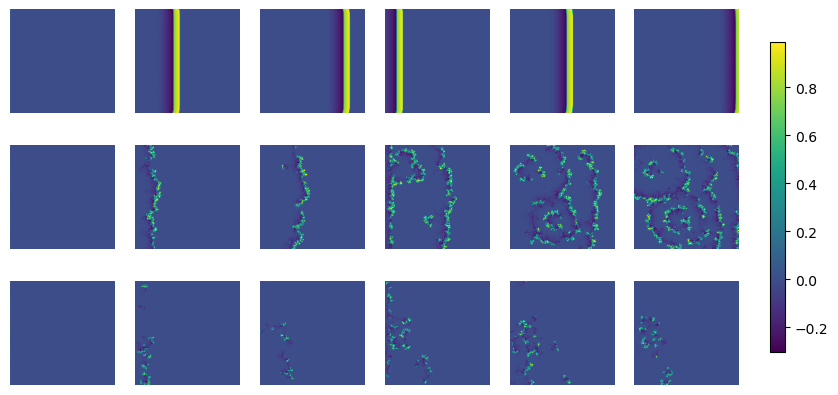

In [14]:
time_frames = [0,1000, 2000, 3000, 4000, 5000]  # Example time frames to plot

fig, axs = plt.subplots(3,len(time_frames), figsize=(10,5))
min_val = min(u_sol.min(), u_sol2.min(), u_sol3.min())
max_val = max(u_sol.max(), u_sol2.max(), u_sol3.max())

for i, t in enumerate(time_frames):
    im1 = axs[0, i].imshow(u_sol[t, :].reshape(N_x, N_y), vmin=min_val, vmax=max_val)
    #axs[0,i].set_title(f'u_sol at t={t}')
    axs[0,i].axis('off')

    im2 = axs[1,i].imshow(u_sol2[t, :].reshape(N_x, N_y), vmin=min_val, vmax=max_val)
    #axs[1,i].set_title(f'u_sol2 at t={t}')
    axs[1,i].axis('off')

    im3 = axs[2,i].imshow(u_sol3[t, :].reshape(N_x, N_y), vmin=min_val, vmax=max_val)
    #axs[2,i].set_title(f'u_sol3 at t={t}')
    axs[2,i].axis('off')

fig.colorbar(im1, ax=axs, fraction=0.02, pad=0.04)
##plt.tight_layout()
plt.show()

In [122]:
# functiom to calculate the rate of u by thresholding

def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)


@jit
def process_element_rate(array, i, j):
    '''
    Process a single element of a binary array to calculate its Shannon entropy.

    Parameters:
    matrix (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y, T),
                                where N_x*N_y is the number of nodes, and T is the number of time steps. 
    i,j : index of the element

    Returns:
    entropy (float): The Shannon entropy of the element.
    '''
    n = array.shape[2]  # Number of time steps
    p_0 = jnp.sum(array[i,j,:] == 0) / n
    p_1 = 1 - p_0  # Since p_0 + p_1 = 1
    p_0 = jnp.clip(p_0, 1e-12, 1.0)  # Avoid log(0)
    p_1 = jnp.clip(p_1, 1e-12, 1.0)  # Avoid log(0)
    
    # Calculate entropy
    entropy = - (p_0 * jnp.log2(p_0) + p_1 * jnp.log2(p_1))

    return entropy


def rate_entropy(array, c1):
    '''
    Calculate the average Shannon entropy of the elements of a binary array disregarding the ones that are conduction blocks.
    Parameters: 
    array (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y, T),
    c1 (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y) where True values indicate conduction blocks.
    
    Returns: 
    average_entropy (float): The average Shannon entropy of the elements of the array.
    '''
    N, M, T = array.shape
    array = array[4:N-4, 4:M-4, :] # Exclude the first and last column and the top and bottom row
    c1 = c1[4:N-4, 4:M-4]
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element_rate(array, i, j))(jnp.arange(M-8)))(jnp.arange(N-8))
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy

#The entropy calculated this way is bullshit: I need to make an histogram of the activity and from that calculate a prob distribution
@jit
def activity_entropy(rate, c1): 
    '''
    Calculate the average Shannon entropy of the global activity of a binary array (1-> active, 0-> inactive) disregarding the elements that are conduction blocks.
    
    Parameters: array (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y, T),
            c1 (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y) where True values indicate conduction blocks.
    
    Returns: entropy (float): The Shannon entropy of the activity of the array.
             activity (jax.numpy.ndarray): The average activity of the array for each time step.
''' 
    # Broadcast c1 to match the shape of rate
    c1=c1[4:N_x-4, 4:N_y-4]
    rate=rate[4:N_x-4, 4:N_y-4, :]
    c1_broadcasted = jnp.broadcast_to(c1[:, :, None], rate.shape)
    masked_rate = jnp.where(c1_broadcasted, jnp.nan, rate)
    masked_rate = masked_rate.reshape((N_x-8) * (N_y-8), -1)
    activity = jnp.nanmean(masked_rate, axis=0)
    
    epsilon=1e-12 
    total_activity = jnp.sum(activity)
    p_act = activity / (total_activity + epsilon)
    entropy = -jnp.sum(p_act * jnp.log2(p_act + epsilon))

    return entropy, activity


@jit
def handle_blocks(array, c1):
    '''
    Calculate the average of an array disregarding the elements that are conduction blocks.
    Parameters:
    array (jax.numpy.ndarray): A matrix of shape N,
    c1 (jax.numpy.ndarray): A binary matrix of shape (N_x, N_y) where True values indicate conduction blocks.
    Returns:
    average (float): The average of the array disregarding the elements that are conduction blocks.
    '''
    c1=c1.flatten()
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, array)
    
    # Calculate the mean entropy, ignoring NaN values
    average = jnp.nanmean(masked_entropy)
    return average


# function to calculate the average of u for each time step disregarding the elements that are conduction blocks
@jit
def compute_averages(u_sol, c1_flat):
    """
    Compute the average of the elements that are False in c1 for each time step in u_sol.
    
    Parameters:
    - u_sol (jax.numpy.ndarray): The solution array of shape (T, N).
    - c1_flat (jax.numpy.ndarray): The conduction block array of shape (N_x,N_y).
    
    Returns:
    - averages (jax.numpy.ndarray): The array of averages for each time step.
    """
    u_sol = u_sol.reshape(5250,N_x, N_y)
    u_sol = u_sol[:,4:N_x-4, 4:N_y-4]  # Exclude the first and last column and the top and bottom row
    u_sol=u_sol.reshape(5250,(N_x-8)*(N_y-8))
    c1_flat=c1_flat[4:N_x-4, 4:N_y-4]
    # Vectorized computation of averages
    averages = vmap(lambda u_t: handle_blocks(u_t, c1_flat))(u_sol)
    return averages

# Compute the averages
#averages = compute_averages(u_sol, c1)


In [ ]:
N=200*200
results_u = []
results_v=[]
# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed = int(conduction_threshold * 10)
    seed2=int(conduction_threshold * 100)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed)   
    
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1,delta_t=0.1, total_time=5250, stimulus_time=750, Nconf=5250, key=random.PRNGKey(seed2))
    u_sol=u_sol.T
    v_sol=v_sol.T
    u_sol=u_sol.reshape(N_x, N_y,5250)
    v_sol=v_sol.reshape(N_x, N_y, 5250)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

In [ ]:
minu=np.min(results_u)
maxu=np.max(results_u)
#minv=np.min(entropy_v)
#maxv=np.max(entropy_v)
print(np.argmax(results_u))
print(np.argmax(results_v))
plt.plot(np.arange(0,0.9,0.01),results_u,label='Entropy of u')
##plt.plot(np.arange(0,0.80,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy PSD')
#plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()
plt.ylim(0)


In [127]:
N=200*200
N_x=200
N_y=200
entropy_u=[]
rate_act=[]
com_act=[]
N=200*200
for conduction_threshold in jnp.arange(0, 0.8, 0.01):
    seed_laplacian = int(conduction_threshold * 10) 
    seed_noise = int(conduction_threshold * 100)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed_laplacian)
    u_sol, v_sol = run_simulation(N=N, L=L1, c1=c1,delta_t=0.1, sigma=0.0001, key=random.PRNGKey(seed_noise), total_time=6500, stimulus_time=1300, Nconf=6500)
    rate = threshold_matrix(u_sol, 0.08)
    rate = rate.T
    rate = rate.reshape(N_x, N_y, -1)
    entropy_u.append(rate_entropy(rate[:,:,3900:], c1))
    entr_act, activity = activity_entropy(rate, c1)
    rate_act.append(activity)
    #com_act.append(compute_averages(u_sol, c1))

In [128]:
# calculate the pmf of the average rate 

def calculate_pmf(array):
    """
    Returns the probability mass function (pmf) of the input array.
    
    Parameters:
    array (numpy.ndarray): Input array of data.
    
    Returns:
    numpy.ndarray: The pmf of the input array.
    """
    
    # Calculate frequencies
    unique, counts = jnp.unique(array, return_counts=True)
    frequencies = counts / len(array)
    
    return frequencies

def entropy_pmf(data):
    '''
    Calculate the entropy of a dataset with discrete values.
    Parameters:
    data (jax.numpy.ndarray): dataset with discrete values.
    Returns:
    float: The entropy of the pmf of the dataset.
    '''
    prob=calculate_pmf(data)
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(prob * jnp.log2(prob + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative


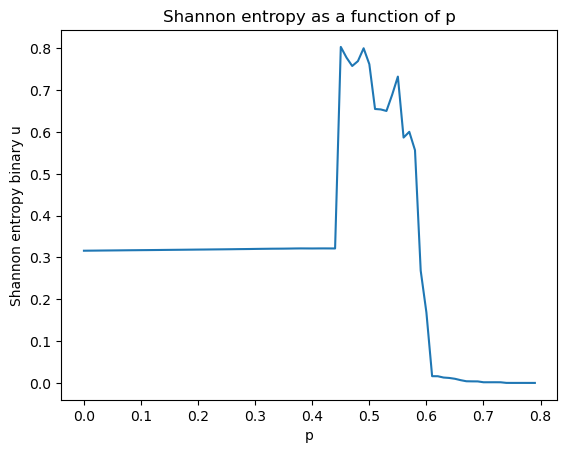

In [130]:
entropy_u = jnp.array(entropy_u)
plt.plot(jnp.arange(0, 0.8, 0.01), entropy_u, label='Entropy of u')
plt.xlabel('p')
plt.ylabel('Shannon entropy binary u')
#plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()


(0.0, 5512.5)

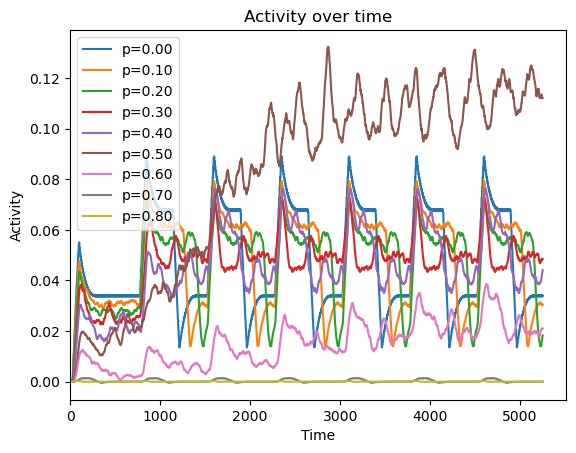

In [23]:

com_act=np.array(com_act)
for i in np.arange(0, 0.90, 0.1):
    plt.plot(np.linspace(0,5250, 5250), com_act[int(i * 100), :], label=f'p={i:.2f}')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.title('Activity over time')
plt.xlim(0)


(0.0, 6825.0)

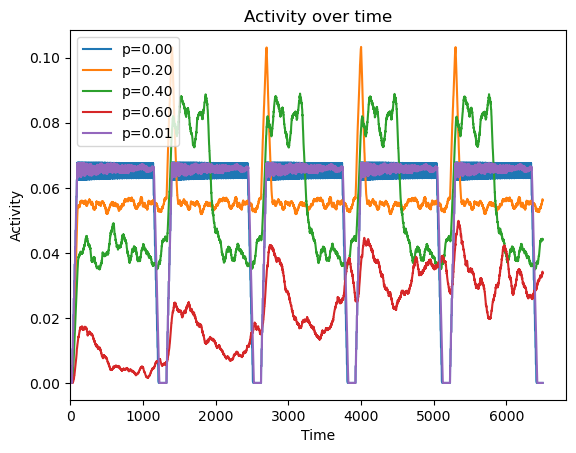

In [159]:
rate_act=np.array(rate_act)
for i in np.arange(0, 0.80, 0.20):
    plt.plot(np.linspace(0,6500, 6500), rate_act[int(i * 100), :], label=f'p={i:.2f}')
plt.plot(np.linspace(0,6500, 6500), rate_act[1, :], label='p=0.01')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.title('Activity over time')
plt.xlim(0)


In [189]:
pmf=[]
for i in range(80):
    pmf.append(calculate_pmf(rate_act[i,3900:]))

Text(0.5, 1.0, 'pmf for p=0.7')

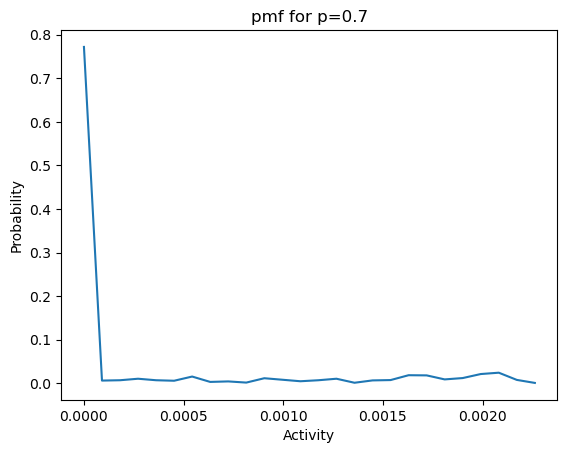

In [190]:
plt.plot( jnp.unique(rate_act[70,:], return_counts=False),pmf[70][:], label='p=0')
plt.xlabel('Activity')
plt.ylabel('Probability')
plt.title('pmf for p=0.7')

In [ ]:
rate_act=rate_act[:,3900:]
ent = [entropy_pmf(mean) for mean in rate_act]

Text(0.5, 1.0, 'Shannon entropy of the activity')

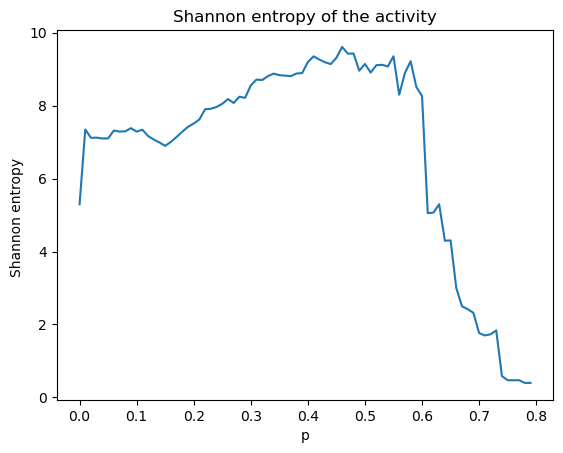

In [196]:
plt.plot(np.arange(0,0.8,0.01),ent)
plt.xlabel('p')
plt.ylabel('Shannon entropy ')
plt.title('Shannon entropy of the activity')
#plt.ylim(0,12)
